In [1]:
import pandas as pd
from pathlib import Path
import json
import csv

In [2]:
%matplotlib inline
import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np

import string
from nltk.corpus import stopwords
stop = stopwords.words("english")
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.svm import LinearSVC

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


#from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_json (r'C:\Users\Owner\Desktop\Pbi_project\Luxury_Beauty.json', lines=True, compression='gzip')
df.to_csv (r'C:\Users\Owner\Desktop\Pbi_project\Luxury_Beauty.csv', index = None)

In [4]:
#Making Dataframe
review_df = pd.read_csv(r'C:\Users\Owner\Desktop\Pbi_project\Luxury_Beauty.csv')
review_df

C:\Users\Owner\AppData\Local\Temp\ipykernel_10768\1606815607.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_df = pd.read_csv(r'C:\Users\Owner\Desktop\Pbi_project\Luxury_Beauty.csv')


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
574623,5,NaN,True,"03 20, 2017",AHYJ78MVF4UQO,B01HIQEOLO,Lori Fox,Great color and I prefer shellac over gel,Five Stars,1489968000,NaN,NaN
574624,5,NaN,True,"10 26, 2016",A1L2RT7KBNK02K,B01HIQEOLO,Elena,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,1477440000,NaN,NaN
574625,5,NaN,True,"09 30, 2016",A36MLXQX9WPPW9,B01HIQEOLO,Donna D. Harris,Great polish and beautiful color!!,Great polish!,1475193600,NaN,NaN
574626,1,2.0,True,"12 5, 2016",A23DRCOMC2RIXF,B01HJ2UY0W,Y.Y. Chen,"The perfume is good, but the spray head broke ...",Spray head broke off within a month,1480896000,"{'Size:': ' 1.7 Fluid Ounce', 'Color:': ' Multi'}",NaN


In [5]:
#Coulmns in dataset
review_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'style',
       'image'],
      dtype='object')

In [6]:
#Dropping the columns not required
review_df=review_df.drop(['vote','verified','reviewTime','style','reviewerName', 'unixReviewTime', 'image'],axis=1)

In [7]:
type(review_df['reviewText'][0])

str

<Axes: xlabel='overall', ylabel='count'>

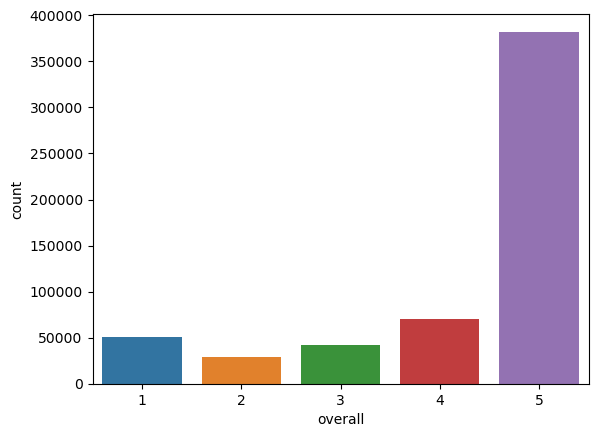

In [8]:
#Count of overall rating
sbn.countplot(x=review_df['overall'])

In [9]:
#Removing Stopwords
def data_clean( rev, remove_stopwords=True): 
    
    new_text = re.sub("[^a-zA-Z]"," ", rev)
   
    words = new_text.lower().split()
    
    if remove_stopwords:
        sts = set(stopwords.words("english"))
        words = [w for w in words if not w in sts]
    ary=[]
    eng_stemmer = english_stemmer 
    for word in words:
        ary.append(eng_stemmer.stem(word))

    
    return(ary)

In [10]:
cleaned_reviewData = []
for rev in review_df['reviewText']:
    #print(rev)
    cleaned_reviewData.append(" ".join(data_clean(str(rev))))
    
clean_summaryData = []
for rev in review_df['summary']:
    clean_summaryData.append(" ".join(data_clean(str(rev))))

In [11]:
#Fetching most frequent words from Review Text
Most_used_Words_Review =pd.Series(' '.join(cleaned_reviewData).lower().split()).value_counts()[:20]
print (Most_used_Words_Review)

use        281569
product    264434
hair       218469
love       163846
skin       137287
great      134290
like       133005
work       106227
one         89420
smell       87709
good        84651
look        83943
get         82326
realli      74017
color       72848
time        72275
dri         72049
feel        71485
make        68207
tri         66954
dtype: int64


In [12]:
#Fetching most frequent words from Review Summary
Most_used_Words_Summary = pd.Series(' '.join(clean_summaryData).lower().split()).value_counts()[:20]
print (Most_used_Words_Summary)

star       159956
five       118793
great       62390
product     52800
love        50635
good        27210
hair        23927
best        23158
work        22307
use         18833
like        17393
one         16244
four        16225
smell       15261
skin        14211
color       11929
nice        11544
amaz         9064
three        8839
ever         8777
dtype: int64


In [13]:
#preparing matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer
text_vectorizer = TfidfVectorizer(min_df=4, max_features = 1000)
test_vector = text_vectorizer.fit_transform(cleaned_reviewData)
tfidf_vector = dict(zip(text_vectorizer.get_feature_names_out(), text_vectorizer.idf_))

In [14]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
# Sentiment Analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
sample_review = review_df.reviewText[:10]
for test in sample_review:
    test
    ss = analyser.polarity_scores(test)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
    print(test)

compound: 0.5423, 
neg: 0.045, 
neu: 0.811, 
pos: 0.144, 
I bought two of these 8.5 fl oz hand cream, and neither of the dispensers work.  The hand cream is wonderful, but very thick, so I don't see I can get much out by shaking it out, since the dispensers seem to be non-operable.
compound: 0.9451, 
neg: 0.026, 
neu: 0.779, 
pos: 0.195, 
Believe me, over the years I have tried many, many different hand creams. I am one of those people whose hands get so dry they have little cracks all over them.

Of all the hand creams, this is the best. It really moisturizes but doesn't leave your hands feeling greasy. And it lasts. I think a lot of lotions just have too much water in them. It has a very nice, subtle scent. I have to avoid a lot of lotions just because the scent is too strong!

I am overall very "frugal" but I think this cream is worth the money.
compound: 0.8074, 
neg: 0.0, 
neu: 0.12, 
pos: 0.88, 
Great hand lotion
compound: 0.296, 
neg: 0.174, 
neu: 0.581, 
pos: 0.244, 
This is th

In [16]:
#Kmeans clusters
from sklearn.cluster import MiniBatchKMeans

clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmodel = kmeans_model.fit(test_vector)
kmodel_clusters = kmodel.predict(test_vector)
kmodel_distances = kmodel.transform(test_vector)
centroids = kmodel.cluster_centers_.argsort()[:, ::-1]
values = text_vectorizer.get_feature_names_out()
for i in range(clusters):
    print("Cluster %d:" % i)
    for j in centroids[i, :5]:
        print(' %s' % values[j])
    print()

Cluster 0:
 like
 younger
 gel
 futur
 full

Cluster 1:
 perfect
 excel
 ok
 wast
 exact

Cluster 2:
 love
 product
 forev
 futur
 full

Cluster 3:
 use
 product
 hair
 love
 great

Cluster 4:
 clarison
 send
 charg
 provid
 back

Cluster 5:
 mask
 ever
 best
 hair
 use

Cluster 6:
 color
 love
 formula
 gave
 futur

Cluster 7:
 guy
 stylist
 cheaper
 short
 hair

Cluster 8:
 love
 product
 color
 smell
 stuff

Cluster 9:
 hair
 straight
 flat
 iron
 day

Cluster 10:
 creme
 well
 lift
 due
 within

Cluster 11:
 use
 skin
 warm
 mask
 cleanser

Cluster 12:
 run
 consist
 flat
 heat
 iron

Cluster 13:
 great
 product
 work
 smell
 price

Cluster 14:
 note
 fragranc
 summer
 floral
 open

Cluster 15:
 curl
 iron
 love
 hair
 heat

Cluster 16:
 leg
 felt
 effect
 first
 time

Cluster 17:
 doesnt
 turn
 white
 makeup
 perfect

Cluster 18:
 anymor
 half
 left
 spray
 formula

Cluster 19:
 good
 product
 smell
 work
 price



In [17]:
test_reviewText = review_df.reviewText
test_Ratings = review_df.overall
text_vectorizer = TfidfVectorizer(max_df=.8)
text_vectorizer.fit_transform(test_reviewText.values.astype('U'))
#v.fit_transform(df['Review'].values.astype('U')) 
def rate(r):
    ary2 = []
    for rating in r:
        tv = [0,0,0,0,0]
        tv[rating-1] = 1
        ary2.append(tv)
    return np.array(ary2)

In [18]:
#Review text
test_reviewText =test_reviewText[:2000]
test_reviewText

0       I bought two of these 8.5 fl oz hand cream, an...
1       Believe me, over the years I have tried many, ...
2                                       Great hand lotion
3       This is the best for the severely dry skin on ...
4       The best non- oily hand cream ever. It heals o...
                              ...                        
1995    Great stuff! Does not smell and kept me odor f...
1996    Excellent product, and although it might seem ...
1997    Sad to report that this very promising product...
1998    it didn't work as i expected it to. my underar...
1999    I have used this product for about 1 year now ...
Name: reviewText, Length: 2000, dtype: object

In [19]:
#Overall ratings
test_Ratings = test_Ratings[:2000]
test_Ratings

0       2
1       5
2       5
3       5
4       5
       ..
1995    5
1996    5
1997    1
1998    2
1999    4
Name: overall, Length: 2000, dtype: int64

In [20]:
X = text_vectorizer.transform(test_reviewText.values.astype('U')).toarray()
y = rate(test_Ratings.values)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1)

#After performing Oversampling (because of high amount of data in with 5 Rating)
over = SMOTE(k_neighbors=3)
X_train, y_train = over.fit_resample(X_train, y_train)

#model implementation
model = Sequential()
model.add(Dense(128,input_dim=X_train.shape[1]))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
map=model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10,batch_size=32,verbose=1)
model.evaluate(X_test,y_test)[1]



Epoch 1/10


203/203 [==============================] - 14s 60ms/step - loss: 0.9715 - accuracy: 0.8125 - val_loss: 0.9380 - val_accuracy: 0.6750
Epoch 2/10
203/203 [==============================] - 11s 54ms/step - loss: 0.2635 - accuracy: 0.9484 - val_loss: 0.8740 - val_accuracy: 0.6650
Epoch 3/10
203/203 [==============================] - 10s 50ms/step - loss: 0.1171 - accuracy: 0.9690 - val_loss: 0.9389 - val_accuracy: 0.6750
Epoch 4/10
203/203 [==============================] - 11s 54ms/step - loss: 0.0737 - accuracy: 0.9794 - val_loss: 1.0557 - val_accuracy: 0.6750
Epoch 5/10
203/203 [==============================] - 12s 62ms/step - loss: 0.0553 - accuracy: 0.9847 - val_loss: 1.1481 - val_accuracy: 0.6750
Epoch 6/10
203/203 [==============================] - 11s 55ms/step - loss: 0.0458 - accuracy: 0.9861 - val_loss: 1.2065 - val_accuracy: 0.6750
Epoch 7/10
203/203 [==============================] - 11s 53ms/step - loss: 0.0393 - accuracy: 0.9886 - val_loss: 1.2848 - val_accur

0.7149999737739563

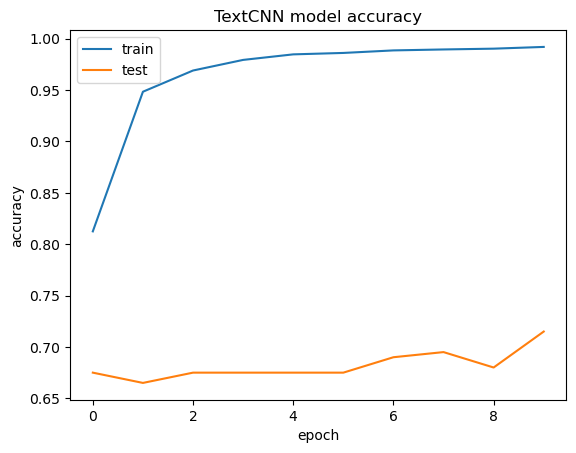

In [22]:
#TextCNN model accuracy graph
plt.plot(map.history['accuracy'])
plt.plot(map.history['val_accuracy'])
plt.title('TextCNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

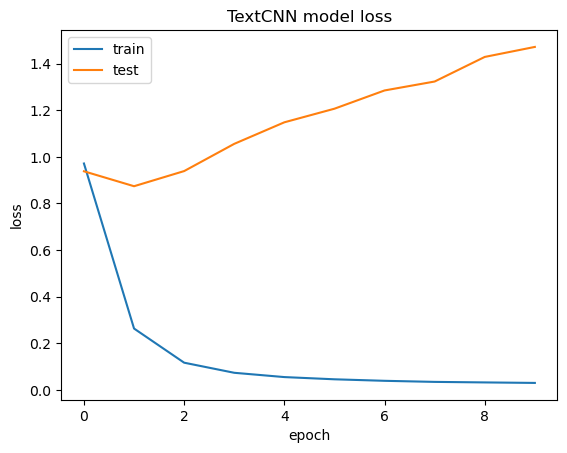

In [23]:
#TextCNN model Loss graph
plt.plot(map.history['loss'])
plt.plot(map.history['val_loss'])
plt.title('TextCNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_10768\988941000.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


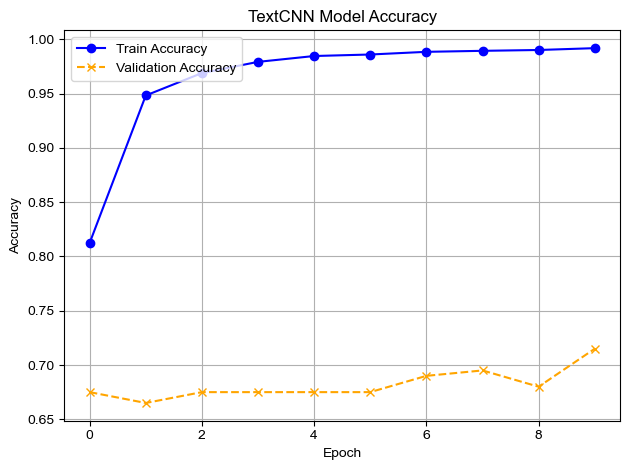

In [24]:
# Assuming 'history' is the variable storing the training history of your TextCNN model
plt.plot(map.history['accuracy'], color='blue', linestyle='-', marker='o', label='Train Accuracy')
plt.plot(map.history['val_accuracy'], color='orange', linestyle='--', marker='x', label='Validation Accuracy')
plt.title('TextCNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Customize the appearance further
plt.grid(True)
plt.style.use('seaborn-darkgrid')
plt.tight_layout()  # Adjust layout for better appearance

plt.show()


C:\Users\Owner\AppData\Local\Temp\ipykernel_10768\1347188204.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


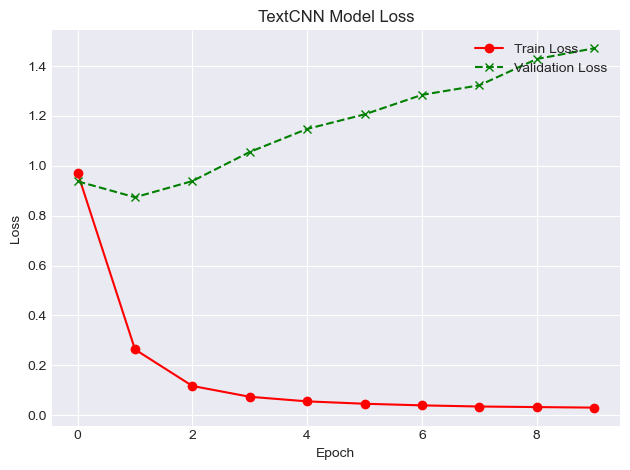

In [25]:
# Assuming 'history' is the variable storing the training history of your TextCNN model
plt.plot(map.history['loss'], color='red', linestyle='-', marker='o', label='Train Loss')
plt.plot(map.history['val_loss'], color='green', linestyle='--', marker='x', label='Validation Loss')
plt.title('TextCNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Customize the appearance further
plt.grid(True)
plt.style.use('seaborn-darkgrid')
plt.tight_layout()  # Adjust layout for better appearance

plt.show()

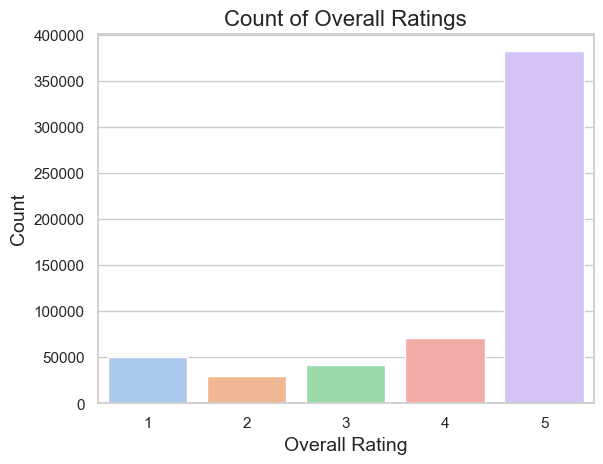

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'review_df' is your DataFrame and 'overall' is the column containing overall ratings
sns.set(style="whitegrid")  # Set the overall style

# Customize the color palette
custom_palette = sns.color_palette("pastel")  # You can choose any other seaborn color palette
sns.set_palette(custom_palette)

# Create the count plot
sns.countplot(x=review_df['overall'])

# Customize the plot further
plt.title('Count of Overall Ratings', fontsize=16)
plt.xlabel('Overall Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()